In [216]:
import numpy as np
import pandas as pd
import pickle
import time
import matplotlib.pyplot as plt
import matplotlib.animation as animation

from tqdm import tqdm
from collections import Counter
from IPython.display import HTML, Javascript

In [2]:
def n_to_vect(n):
    canonic_base = np.zeros(47)
    canonic_base[n] = 1
    return canonic_base

In [3]:
def sigma (x):
    return 1/(1+ np.exp(-x))

In [71]:
def batch_iterator(X, y = None, batch_size = 64):

    n_samples = X.shape[0]
    for i in np.arange(0, n_samples, batch_size):
        begin, end = i, min(i+batch_size, n_samples)
        if y is not None:
            yield X[begin:end], y[begin:end]
        else:
            yield X[begin:end]

In [5]:
def imageTransposer(img):
    return np.array([img[(i*int(len(img) ** 0.5))%(len(img)-1)]/225 for i in range(len(img))])

In [6]:
def grayToBlack(img, eps):
    for i in range(len(img)):
        img[i] = 0 if img[i]<eps else 1
    return img

In [223]:
def updatefig(i):
    im.set_array(x[i])
    return im,

In [89]:
class RBM():
    
    def __init__(self, n_visible, n_hidden, learning_rate = 0.1, batch_size = 10, n_iterations = 100):
        
        self.n_visible = n_visible
        self.n_hidden = n_hidden
        self.lr = learning_rate
        self.batch_size = batch_size
        self.n_iterations = n_iterations
        
        self.training_errors = []
        self.training_reconstructions = []
        self.W = np.zeros(shape = (n_visible, self.n_hidden))
        self.v0 = np.zeros(n_visible)       # Bias visible
        self.h0 = np.zeros(self.n_hidden)   # Bias hidden
    
    def _initialize_weights(self, X):
        self.W = np.random.normal(scale=0.1, size=(self.n_visible, self.n_hidden))

    def _mean_hiddens(self, v):
        #Computes the probabilities P(h=1|v). 
        
        return sigma(v.dot(self.W) + self.h0)
    
    def _sample_hiddens(self, v):
        #Sample from the distribution P(h|v).
        
        p = self._mean_hiddens(v)
        return self._sample(p)
    
    def _sample_visibles(self, h):
        #Sample from the distribution P(v|h).
        
        p = sigma(h.dot(self.W.T) + self.v0)
        return self._sample(p)
    
    def _gibbs(self, v):
        #Perform one Gibbs sampling step.
        
        h_ = self._sample_hiddens(v)
        v_ = self._sample_visibles(h_)

        return v_
    
    def _sample(self, X):
        return X > np.random.random_sample(size = X.shape)
    
    def _CD1(self, X):

        self._initialize_weights(X)

        for _ in tqdm(range(self.n_iterations)):
            batch_errors = []
            for batch in batch_iterator(X, batch_size = self.batch_size):
                
                # Positive phase
                positive_hidden = self._mean_hiddens(batch)
                positive_associations = batch.T.dot(positive_hidden)
                hidden_states = self._sample_hiddens(batch)
                
                # Negative phase
                negative_visible = self._sample_visibles(hidden_states)
                negative_hidden = self._mean_hiddens(negative_visible)
                negative_associations = negative_visible.T.dot(negative_hidden)
                
                self.W  += self.lr * (positive_associations - negative_associations)
                self.h0 += self.lr * (positive_hidden.sum(axis = 0) - negative_hidden.sum(axis = 0))
                self.v0 += self.lr * (batch.sum(axis = 0) - negative_visible.sum(axis = 0))

                batch_errors.append(np.mean((batch - negative_visible) ** 2))

            self.training_errors.append(np.mean(batch_errors))
            # Reconstruct a batch of images from the training set
            self.training_reconstructions.append(self._reconstruct(X[:25])) 

    def _reconstruct(self, X):
        positive_hidden = sigma(X.dot(self.W) + self.h0)
        hidden_states = self._sample(positive_hidden)
        negative_visible = sigma(hidden_states.dot(self.W.T) + self.v0)
        return negative_visible
    
    def _save(self):
        path = "trained/RBM_"+str(self.n_hidden)+"_lr_"+str(self.lr)+"_iter_"+str(self.n_iterations)+".csv"
        f = open(path, "wb")
        pickle.dump(self.__dict__, f)
        f.close()

In [8]:
def loadRBM(path):
        f = open(path, "rb")
        aux = pickle.load(f)
        rbm = RBM(n_visible = aux["n_visible"] ,
                  n_hidden = aux["n_hidden"], 
                  n_iterations = aux["n_iterations"], 
                  batch_size = aux["batch_size"], 
                  learning_rate = aux["learning_rate"])
        
        rbm.training_errors = aux["training_errors"]
        rbm.training_reconstructions = aux["training_reconstructions"]
        rbm.W = aux["W"]
        rbm.v0 = aux["v0"]
        rbm.h0 = aux["h0"]
        
        return rbm

In [82]:
def processingData(train_data, test_data, eps = 0.4, canonic = False):
    
    train_set = np.array([grayToBlack(imageTransposer(img),eps) for img in tqdm(np.asfarray(train_data)[:30,1:])])
    test_set = np.array([grayToBlack(imageTransposer(img),eps) for img in np.asfarray(test_data)[:30,1:]])
    
    train_label = np.array(train_data)[:30,0]
    test_label = np.array(test_data)[:30,0]
    
    if canonic:
        train_label = [n_to_vect(x) for x in train_label]
        test_label = [n_to_vect(x) for x in test_label]
    
    return int(len(train_set[0]) ** 0.5), train_set, test_set, train_label, test_label

In [81]:
[np.array([1,2,4])]

[array([1, 2, 4])]

In [10]:
train_data = pd.read_csv('data/emnist-train.csv', delimiter = ',')
test_data = pd.read_csv('data/emnist-test.csv', delimiter = ',')

In [83]:
LABELS = ['0', '1', '2', '3', '4', '5', '6', '7', '8', '9', 
          'A', 'B', 'C', 'D', 'E', 'F', 'G', 'H', 'I', 'J', 'K', 'L', 'M', 'N', 'O', 'P', 'Q', 'R', 'S', 'T', 'U', 'V', 'W', 'X', 'Y', 'Z']

dim, train_set, test_set, train_label, test_label = processingData(train_data, test_data, 0.6)

100%|█████████████████████████████████████████████████████████████████████████████████| 30/30 [00:00<00:00, 947.34it/s]


## prima analisi dei dati

100%|██████████████████████████████████████████████████████████████████████████████████| 25/25 [00:01<00:00, 18.35it/s]


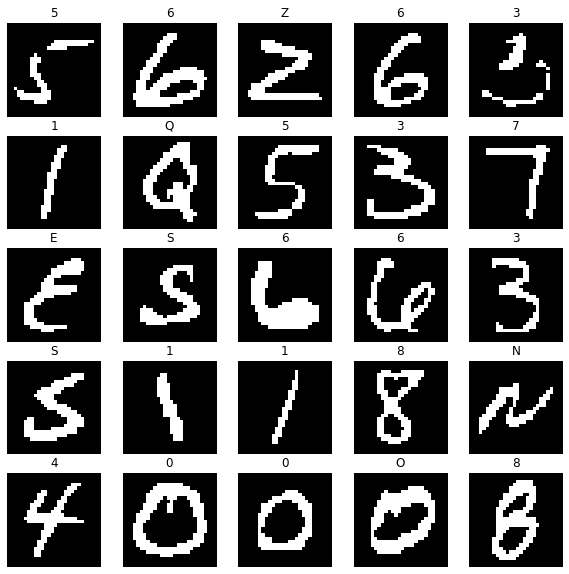

In [84]:
plt.figure(figsize=(10, 10))

for i in tqdm(range(25)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(train_set[i].reshape((28, 28)), cmap='gray')
    plt.title(LABELS[train_label[i]])
    plt.axis('off')
        
plt.show()
plt.close()

<BarContainer object of 17 artists>

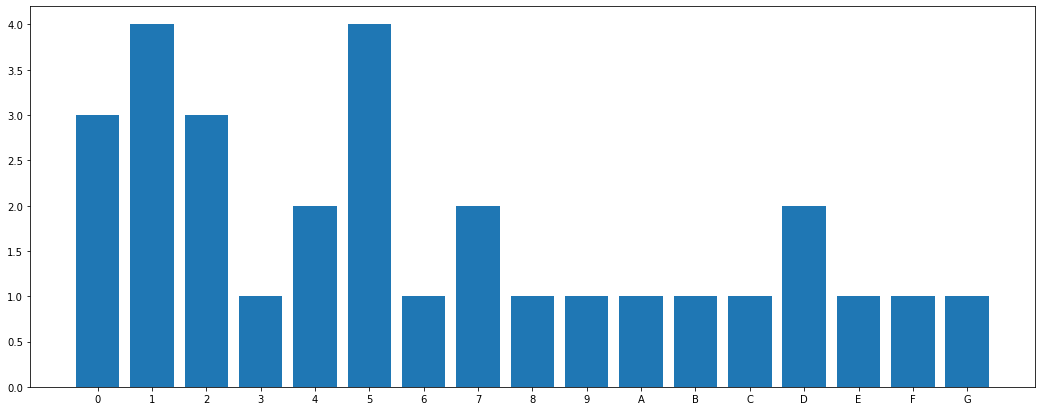

In [85]:
counter = Counter(train_label)
counter = sorted(counter.items())

value = [num for _,num in counter]

plt.figure(figsize = (18, 7))
plt.bar(LABELS[:len(value)], value)

# cosa succede durante l addestramento nei nodi visibili

In [224]:
rbm = RBM(n_visible = dim*dim, n_hidden = dim*dim, n_iterations = 100, batch_size = 1, learning_rate = 0.001)
rbm._CD1(np.array(train_set[23], ndmin = 2))

gen_imgs = rbm.training_reconstructions
fig = plt.figure()

x = [img.reshape((28,28)) for img in gen_imgs]
im = plt.imshow(x[0], animated = False, cmap = 'gray')
plt.close()

anim = animation.FuncAnimation(fig = fig, func = updatefig, frames = len(x) if len(x)<60 else 70, interval = 50, blit = True)
display(HTML(anim.to_jshtml(default_mode = "once")))
time.sleep(0.5)
Javascript('document.querySelector(".anim-buttons > button:nth-child(6)").click()')

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 117.76it/s]


<IPython.core.display.Javascript object>

## addestra e salva

In [91]:
rbm = RBM(n_visible = dim*dim, n_hidden = 100, n_iterations = 100, batch_size = 25, learning_rate = 0.001)
rbm._CD1(train_set[:500])

100%|███████████████████████████████████████████████████████████████████████████████| 100/100 [00:00<00:00, 355.64it/s]


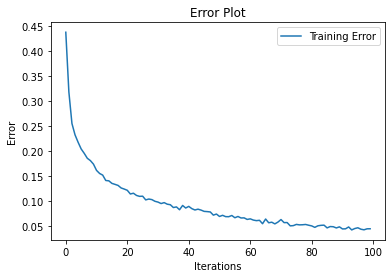

In [201]:
# Training error plot
training, = plt.plot(range(len(rbm.training_errors)), rbm.training_errors, label = "Training Error")
plt.legend(handles = [training])
plt.title("Error Plot")
plt.ylabel('Error')
plt.xlabel('Iterations')
plt.show()

# best rbm

  4%|███▎                                                                               | 1/25 [00:00<00:00, 40.16it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

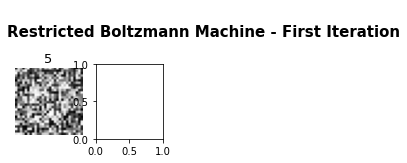

In [214]:
# Get the images that were reconstructed during training
gen_imgs = rbm.training_reconstructions

# Plot the reconstructed images during the first iteration
plt.figure(figsize=(7, 8))
plt.suptitle("\nRestricted Boltzmann Machine - First Iteration", fontsize = 15, fontweight="bold")

for i in tqdm(range(25)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[0][i].reshape((28, 28)), cmap='gray')
    plt.title(LABELS[train_label[i]], fontsize = 13)
    plt.axis('off')
#fig.savefig("rbm_first.png")
plt.show()
plt.close()

  4%|███▎                                                                               | 1/25 [00:00<00:00, 38.83it/s]


IndexError: index 1 is out of bounds for axis 0 with size 1

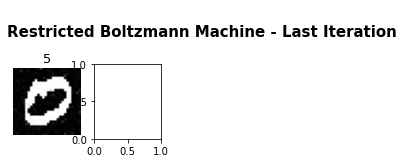

In [213]:
# Plot the images during the last iteration
plt.figure(figsize=(7, 8))
plt.suptitle("\nRestricted Boltzmann Machine - Last Iteration", fontsize = 15, fontweight="bold")

for i in tqdm(range(25)):
    ax = plt.subplot(5, 5, i+1)
    plt.imshow(gen_imgs[-1][i].reshape((28, 28)), cmap='gray')
    plt.title(LABELS[train_label[i]], fontsize = 13)
    plt.axis('off')
#fig.savefig("rbm_last.png")
plt.show()
plt.close()

## Image Reconstruction using RBM

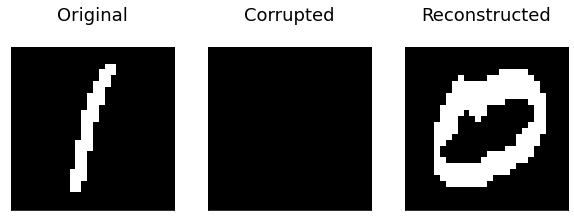

In [212]:
# Pick another random image and set some parts of the image to zero.
im_ind = 5
miss = 1
X_missing = train_set[im_ind].copy().reshape(28,28)
X_missing[:,miss:] = 0

# Image Reconstruction
k_iter = 200 # Number of Gibbs iterations
alpha = 1.1 # Decay factor

X_recon = np.zeros((28,28-miss)) # Array to store the reconstruction
##### BOHHHH
b = X_missing.copy().reshape(-1)

for i in range(k_iter):
    b = rbm._gibbs(b)
    X_recon += alpha**(i) * b.reshape(28,28)[:,miss:]
    b.reshape(28,28)[:,:miss] = X_missing[:,:miss]

# Apply a threshold and complete the image
X_recon = np.where(X_recon > 0.5*np.max(X_recon), 1, 0)
X_complete = X_missing.copy()
X_complete[:,miss:] = X_recon

# Plot the figures
fig, ax = plt.subplots(1, 3, figsize=(10, 3))
ax[0].imshow(train_set[im_ind].reshape(28, 28), cmap = 'gray')
ax[0].set_title('Original\n', fontsize = 18)
ax[1].imshow(X_missing, cmap ='gray')
ax[1].set_title('Corrupted\n', fontsize = 18)
ax[2].imshow(X_complete.reshape(28,28), cmap = 'gray')
ax[2].set_title('Reconstructed\n', fontsize = 18)
for i in range(3):
    ax[i].set_xticks([])
    ax[i].set_yticks([])
plt.show()